Before running the code, please download the required package first like torch, numpy ...

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import init
import math
import torch.nn as nn
import torch.nn.functional as F
import os

d:\Anaconda\envs\GPU_Pytorchpy39\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


The code below will automatically create a path './data' and download MNIST dataset

In [2]:
transform = transforms.Compose(
    [torchvision.transforms.ToTensor()])

batch_size = 64

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

Define the hardware tuning property <--- Hardware-aware training

In [3]:
def lorentzian_curve(x, A, x0, gamma):
    return -2 * A / (1 + ((x - x0) / gamma)**2) +A
def lorentzian_curve_derivative(x, A, x0, gamma):
    return 2 * A * (x - x0) / (gamma**2 * (1 + ((x - x0) / gamma)**2)**2)
def lorentzian_inv(y, A, x0, gamma):
    return gamma * ((A + y)/(A - y)) ** (1/2) + x0

Self defines the convolution layer and linear layer <--- Now we are optimizing the tuning currents/voltages, which differs directly optimizing the weights ! This is a very important step !

In [4]:
from torch.nn.modules.conv import _ConvNd
from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
from torch.nn.modules.utils import _pair
from typing import Optional, List, Tuple, Union

In [5]:
class Conv2dLorentz(_ConvNd):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = 'zeros',  # TODO: refine this type
        device=None,
        dtype=None
    ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        kernel_size_ = _pair(kernel_size)
        stride_ = _pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        super().__init__(
            in_channels, out_channels, kernel_size_, stride_, padding_, dilation_,
            False, _pair(0), groups, bias, padding_mode, **factory_kwargs)

    def _conv_forward(self, input: torch.Tensor, weight: torch.Tensor, bias: Optional[torch.Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self._conv_forward(input, lorentzian_curve(self.weight, 1, 0, 0.15), self.bias) ### <--- Here self.weight is voltage or current

In [6]:
class LinearLorentz(torch.nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(lorentzian_curve(self.weight, 1, 0, 0.15), a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(lorentzian_curve(self.weight, 1, 0, 0.15))
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, lorentzian_curve(self.weight, 1, 0, 0.15), self.bias) ### <--- Here self.weight is voltage or current

    def extra_repr(self) -> str:
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'


In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm1d(120)
        self.norm4 = nn.BatchNorm1d(84)

    def forward(self,x):

        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), (2, 2))

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.norm4(x)
        x = F.relu(x)   
        x = self.fc3(x)

        return x

    def apply_constraints(self):
        self.conv1.cuda().weight.data = torch.clamp(self.conv1.cuda().weight.data, -0.999, 0.999)
        self.conv2.cuda().weight.data = torch.clamp(self.conv2.cuda().weight.data, -0.999, 0.999)
        self.fc1.cuda().weight.data = torch.clamp(self.fc1.cuda().weight.data, -0.999, 0.999)
        self.fc2.cuda().weight.data = torch.clamp(self.fc2.cuda().weight.data, -0.999, 0.999)
        self.fc3.cuda().weight.data = torch.clamp(self.fc3.cuda().weight.data, -0.999, 0.999)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net = LeNet5()
net.to(device)

cuda:0


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [8]:
class LeNet5_Lorentz(nn.Module):
    def __init__(self):
        super(LeNet5_Lorentz, self).__init__()

        self.conv1 = Conv2dLorentz(1, 6, 5, padding=2)
        self.conv2 = Conv2dLorentz(6, 16, 5)
        self.fc1 = LinearLorentz(16*5*5, 120)
        self.fc2 = LinearLorentz(120, 84)
        self.fc3 = LinearLorentz(84, 10)
        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm1d(120)
        self.norm4 = nn.BatchNorm1d(84)

    def forward(self,x):

        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), (2, 2))
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.norm4(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

    def apply_constraints(self):
        self.conv1.cuda().weight.data = torch.clamp(self.conv1.cuda().weight.data, min=0)
        self.conv2.cuda().weight.data = torch.clamp(self.conv2.cuda().weight.data, min=0)
        self.fc1.cuda().weight.data = torch.clamp(self.fc1.cuda().weight.data, min=0)
        self.fc2.cuda().weight.data = torch.clamp(self.fc2.cuda().weight.data, min=0)
        self.fc3.cuda().weight.data = torch.clamp(self.fc3.cuda().weight.data, min=0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net_Lorentz = LeNet5_Lorentz()
net_Lorentz.to(device)

cuda:0


LeNet5_Lorentz(
  (conv1): Conv2dLorentz(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2dLorentz(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): LinearLorentz(in_features=400, out_features=120, bias=True)
  (fc2): LinearLorentz(in_features=120, out_features=84, bias=True)
  (fc3): LinearLorentz(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### Standard Backpropagation Optimize weights

In [28]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 400, gamma = 0.5)

In [29]:
net.to(device)
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss0 = criterion(outputs, labels)
        loss = loss0
        loss.backward()
        optimizer.step()
        net.apply_constraints()
        running_loss += loss.item()
        if i % 600 == 599: 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 600:.3f} Classification loss:{loss0.cpu().detach().numpy():.3f}')
            running_loss = 0.0
    scheduler.step()
    net.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)          
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy 10000 test images: {100 * correct / total} %')
print('Finished Training')

[1,   600] loss: 0.360 Classification loss:0.126
Accuracy 10000 test images: 97.89 %
[2,   600] loss: 0.083 Classification loss:0.054
Accuracy 10000 test images: 98.49 %
[3,   600] loss: 0.056 Classification loss:0.021
Accuracy 10000 test images: 98.56 %
[4,   600] loss: 0.042 Classification loss:0.008
Accuracy 10000 test images: 98.58 %
[5,   600] loss: 0.034 Classification loss:0.030
Accuracy 10000 test images: 98.76 %
[6,   600] loss: 0.030 Classification loss:0.021
Accuracy 10000 test images: 98.88 %
[7,   600] loss: 0.025 Classification loss:0.047
Accuracy 10000 test images: 98.85 %
[8,   600] loss: 0.022 Classification loss:0.040
Accuracy 10000 test images: 98.9 %
[9,   600] loss: 0.018 Classification loss:0.009
Accuracy 10000 test images: 98.92 %
[10,   600] loss: 0.018 Classification loss:0.035
Accuracy 10000 test images: 98.84 %
[11,   600] loss: 0.016 Classification loss:0.008
Accuracy 10000 test images: 98.92 %
[12,   600] loss: 0.015 Classification loss:0.006
Accuracy 10000

-0.32188386
0.6846026


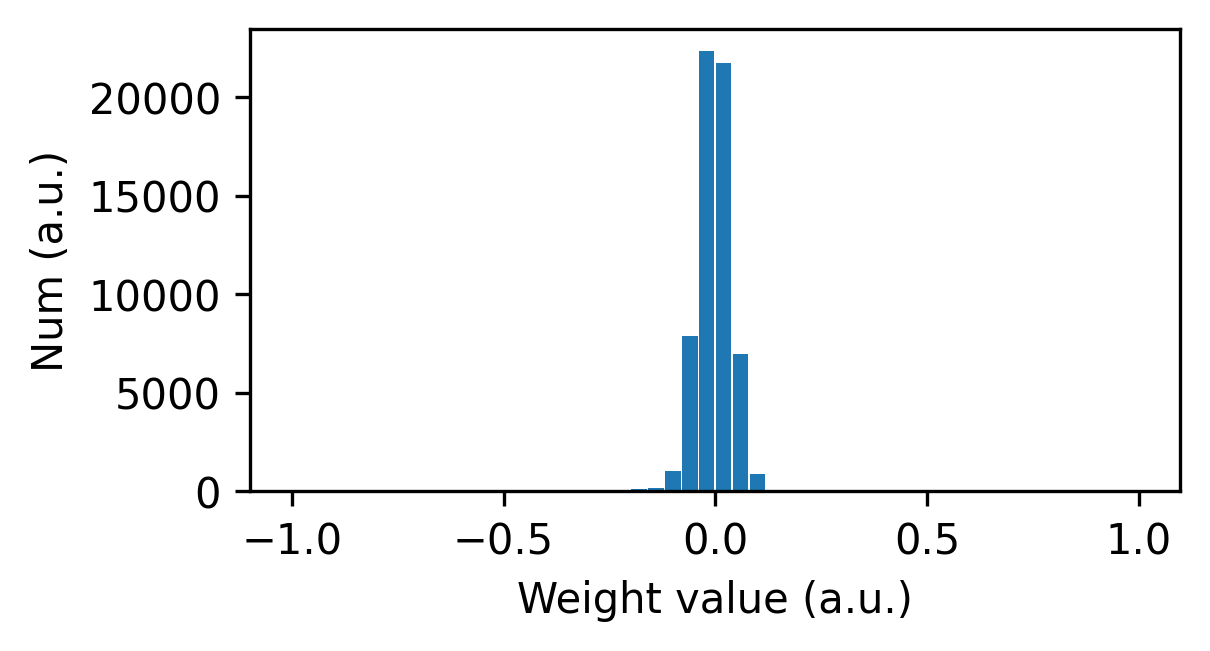

In [30]:
conv1_flat = net.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat,fc3_flat))
print(np.min(total_weight))
print(np.max(total_weight))
plt.figure(figsize=(4,2),dpi=300)
plt.hist(total_weight,bins=50,range=(-1,1),rwidth=0.9)
plt.xlabel('Weight value (a.u.)')
plt.ylabel('Num (a.u.)')
plt.show()

In [31]:
file_name = '.\Training results/01-Standard BP.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net.state_dict(), file_name)
    print('save done')

save done


### Standard Noise injection Optimize weights
Reference: 

[1] Mourgias-Alexandris, G., Moralis-Pegios, M., Tsakyridis, A., Simos, S., Dabos, G., Totovic, A., ... & Pleros, N. (2022). Noise-resilient and high-speed deep learning with coherent silicon photonics. Nature communications, 13(1), 5572. 

[2] Wu, C., Yang, X., Yu, H., Peng, R., Takeuchi, I., Chen, Y., & Li, M. (2022). Harnessing optoelectronic noises in a photonic generative network. Science advances, 8(3), eabm2956.

In [9]:
net = LeNet5()
net.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [10]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 400, gamma = 0.5)

In [11]:
net.to(device)
for epoch in range(100):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        ### Noise injection
        conv1_data = net.conv1.weight.data
        conv2_data = net.conv2.weight.data
        fc1_data = net.fc1.weight.data
        fc2_data = net.fc2.weight.data        
        fc3_data = net.fc3.weight.data     
        # net.conv1.weight.data = conv1_data + 0.5 * torch.randn(net.conv1.weight.data.shape).to(device)
        # net.conv2.weight.data = conv2_data + 0.5 * torch.randn(net.conv2.weight.data.shape).to(device)
        # net.fc1.weight.data = fc1_data + 0.5 * torch.randn(net.fc1.weight.data.shape).to(device)
        net.fc2.weight.data = fc2_data + 0.5 * torch.randn(net.fc2.weight.data.shape).to(device)
        net.fc3.weight.data = fc3_data + 0.5 * torch.randn(net.fc3.weight.data.shape).to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss0 = criterion(outputs, labels)
        loss = loss0
        net.conv1.weight.data = conv1_data 
        net.conv2.weight.data = conv2_data 
        net.fc1.weight.data = fc1_data 
        net.fc2.weight.data = fc2_data 
        net.fc3.weight.data = fc3_data 
        
        loss.backward()
        optimizer.step()
        net.apply_constraints()
        running_loss += loss.item()
        if i % 600 == 599:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 600:.3f} Classification loss:{loss0.cpu().detach().numpy():.3f}')
            running_loss = 0.0
    scheduler.step()
    net.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)        
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy 10000 test images: {100 * correct / total} %')
print('Finished Training')

[1,   600] loss: 3.537 Classification loss:2.239
Accuracy 10000 test images: 39.64 %
[2,   600] loss: 2.171 Classification loss:2.022
Accuracy 10000 test images: 29.8 %
[3,   600] loss: 2.008 Classification loss:1.970
Accuracy 10000 test images: 30.05 %
[4,   600] loss: 1.846 Classification loss:1.763
Accuracy 10000 test images: 31.04 %
[5,   600] loss: 1.785 Classification loss:1.745
Accuracy 10000 test images: 30.68 %
[6,   600] loss: 1.751 Classification loss:1.808
Accuracy 10000 test images: 31.76 %
[7,   600] loss: 1.732 Classification loss:1.694
Accuracy 10000 test images: 35.68 %
[8,   600] loss: 1.711 Classification loss:1.766
Accuracy 10000 test images: 39.17 %
[9,   600] loss: 1.640 Classification loss:1.662
Accuracy 10000 test images: 40.26 %
[10,   600] loss: 1.581 Classification loss:1.298
Accuracy 10000 test images: 42.03 %
[11,   600] loss: 1.533 Classification loss:1.565
Accuracy 10000 test images: 46.93 %
[12,   600] loss: 1.476 Classification loss:1.367
Accuracy 10000

-0.999
0.999


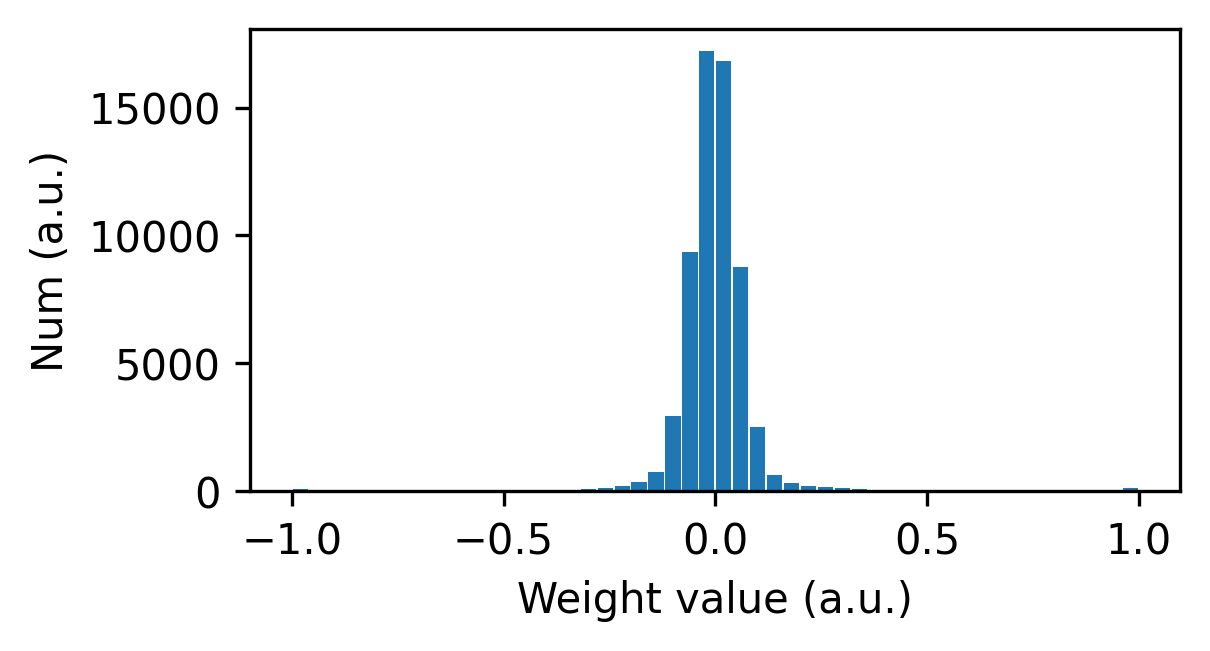

In [12]:
conv1_flat = net.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat,fc3_flat))
print(np.min(total_weight))
print(np.max(total_weight))
plt.figure(figsize=(4,2),dpi=300)
plt.hist(total_weight,bins=50,range=(-1,1),rwidth=0.9)
plt.xlabel('Weight value (a.u.)')
plt.ylabel('Num (a.u.)')
plt.show()

In [13]:
file_name = '.\Training results/02-Standard NJ.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net.state_dict(), file_name)
    print('save done')

save done


### Pruning
Reference: 

[1] Xu, T., Zhang, W., Zhang, J., Luo, Z., Xiao, Q., Wang, B., ... & Huang, C. (2024). Control-free and efficient integrated photonic neural networks via hardware-aware training and pruning. Optica, 11(8), 1039-1049.

In [9]:
net = LeNet5()

In [10]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.5)

In [1]:
### To push as much weights to 1 while without reducing the accuracy, you need to use small learning rate, large epoch number and small regualrization coefficient
net.to(device)
for epoch in range(200):  
    running_loss = 0.0
    net.apply_constraints()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss0 = criterion(outputs, labels)
        regu_num1 = torch.tensor(1*1e-2)
        regu_num1 = regu_num1.to(device)
        net.apply_constraints()
        ### Calculate the regularization term
        conv1_grad = lorentzian_curve_derivative(lorentzian_inv(net.conv1.weight, 1, 0, 0.15), 1, 0, 0.15)
        conv2_grad = lorentzian_curve_derivative(lorentzian_inv(net.conv2.weight, 1, 0, 0.15), 1, 0, 0.15)
        fc1_grad = lorentzian_curve_derivative(lorentzian_inv(net.fc1.weight, 1, 0, 0.15), 1, 0, 0.15)
        fc2_grad = lorentzian_curve_derivative(lorentzian_inv(net.fc2.weight, 1, 0, 0.15), 1, 0, 0.15)
        fc3_grad = lorentzian_curve_derivative(lorentzian_inv(net.fc3.weight, 1, 0, 0.15), 1, 0, 0.15)
        regu = torch.mul(torch.norm(fc1_grad, p=2),regu_num1) + torch.mul(torch.norm(fc2_grad, p=2),regu_num1) + torch.mul(torch.norm(fc3_grad, p=2),regu_num1) + torch.mul(torch.norm(conv1_grad, p=2),regu_num1) + torch.mul(torch.norm(conv2_grad, p=2),regu_num1)
        loss = loss0 + regu * 1
        loss.backward()
        optimizer.step()
        net.apply_constraints()
        running_loss += loss.item()
        if i % 600 == 599:   
            print(f'[{epoch + 1}, {i + 1:5d}] Classification loss:{loss0.cpu().detach().numpy():.3f} Regularization loss:{regu.cpu().detach().numpy()}')
            running_loss = 0.0

    scheduler.step()
    net.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)         
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy 10000 test images: {100 * correct / total} %')
print('Finished Training')

-0.999
0.999


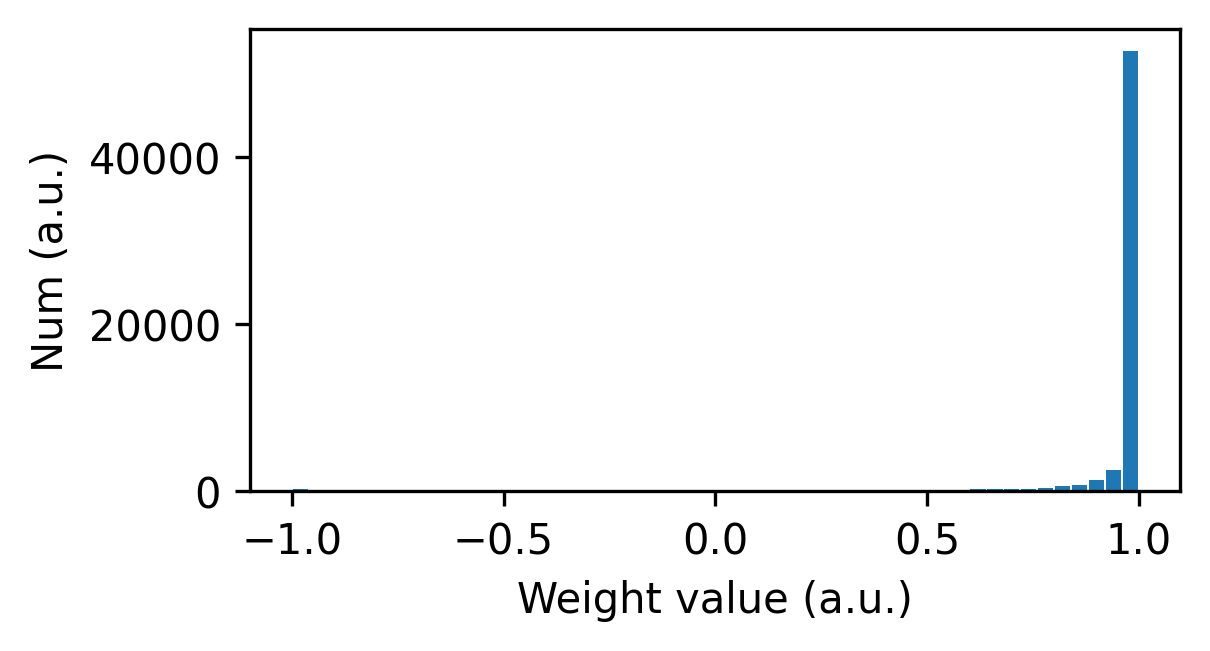

In [13]:
conv1_flat = net.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat,fc3_flat))
print(np.min(total_weight))
print(np.max(total_weight))
plt.figure(figsize=(4,2),dpi=300)
plt.hist(total_weight,bins=50,range=(-1,1),rwidth=0.9)
plt.xlabel('Weight value (a.u.)')
plt.ylabel('Num (a.u.)')
plt.show()

In [ ]:
file_name = '.\Training results/03-Pruning.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net.state_dict(), file_name)
    print('save done')

### SAT in-silico (This work)

In [46]:
from sam import SAM

In [47]:
net = LeNet5()
net.to(device)
net_Lorentz = LeNet5_Lorentz()
net_Lorentz.to(device)

LeNet5_Lorentz(
  (conv1): Conv2dLorentz(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2dLorentz(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): LinearLorentz(in_features=400, out_features=120, bias=True)
  (fc2): LinearLorentz(in_features=120, out_features=84, bias=True)
  (fc3): LinearLorentz(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [48]:
net_Lorentz.conv1.weight.data = lorentzian_inv(net.conv1.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.conv2.weight.data = lorentzian_inv(net.conv2.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.fc1.weight.data = lorentzian_inv(net.fc1.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.fc2.weight.data = lorentzian_inv(net.fc2.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.fc3.weight.data = lorentzian_inv(net.fc3.weight.data, A=1, x0=0, gamma=0.15)

In [49]:
conv1_flat = net_Lorentz.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net_Lorentz.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net_Lorentz.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net_Lorentz.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net_Lorentz.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat, fc3_flat))

In [50]:
net_Lorentz.to(device)
base_optimizer = torch.optim.Adam
optimizer = SAM(net_Lorentz.parameters(), rho=0.5, base_optimizer=base_optimizer,lr=0.01,adaptive=True)
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        ### First forward propagation
        outputs = net_Lorentz(inputs)
        loss0 = criterion(outputs, labels)
        loss = loss0
        optimizer.zero_grad()
        loss.backward()
        optimizer.first_step(zero_grad=True)
        ### Second forward propagation
        outputsSAM = net_Lorentz(inputs)
        lossSAM0 = criterion(outputsSAM, labels)
        lossSAM = lossSAM0
        lossSAM.backward()
        optimizer.second_step(zero_grad=True) 
        running_loss += loss.item()
        if i % 600 == 599:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 600:.3f}')
            running_loss = 0.0
    scheduler.step()

    net_Lorentz.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net_Lorentz(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy 10000 test images: {100 * correct / total} %')
print('Finished Training')

[1,   600] loss: 0.173


d:\Anaconda\envs\GPU_Pytorchpy39\lib\site-packages\torch\optim\lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Accuracy 10000 test images: 98.61 %
[2,   600] loss: 0.052
Accuracy 10000 test images: 98.63 %
[3,   600] loss: 0.040
Accuracy 10000 test images: 98.87 %
[4,   600] loss: 0.036
Accuracy 10000 test images: 98.5 %
[5,   600] loss: 0.048
Accuracy 10000 test images: 97.94 %
[6,   600] loss: 0.068
Accuracy 10000 test images: 98.43 %
[7,   600] loss: 0.053
Accuracy 10000 test images: 98.53 %
[8,   600] loss: 0.055
Accuracy 10000 test images: 98.43 %
[9,   600] loss: 0.053
Accuracy 10000 test images: 98.48 %
[10,   600] loss: 0.050
Accuracy 10000 test images: 98.56 %
[11,   600] loss: 0.049
Accuracy 10000 test images: 98.44 %
[12,   600] loss: 0.045
Accuracy 10000 test images: 98.54 %
[13,   600] loss: 0.050
Accuracy 10000 test images: 98.52 %
[14,   600] loss: 0.048
Accuracy 10000 test images: 98.4 %
[15,   600] loss: 0.048
Accuracy 10000 test images: 98.37 %
[16,   600] loss: 0.048
Accuracy 10000 test images: 98.53 %
[17,   600] loss: 0.044
Accuracy 10000 test images: 98.24 %
[18,   600] lo

In [52]:
conv1_flat = net_Lorentz.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net_Lorentz.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net_Lorentz.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net_Lorentz.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net_Lorentz.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat, fc3_flat))
print(np.min(lorentzian_curve(total_weight, A=1, x0=0, gamma=0.15)))
print(np.max(lorentzian_curve(total_weight, A=1, x0=0, gamma=0.15)))

-1.0
0.9983407


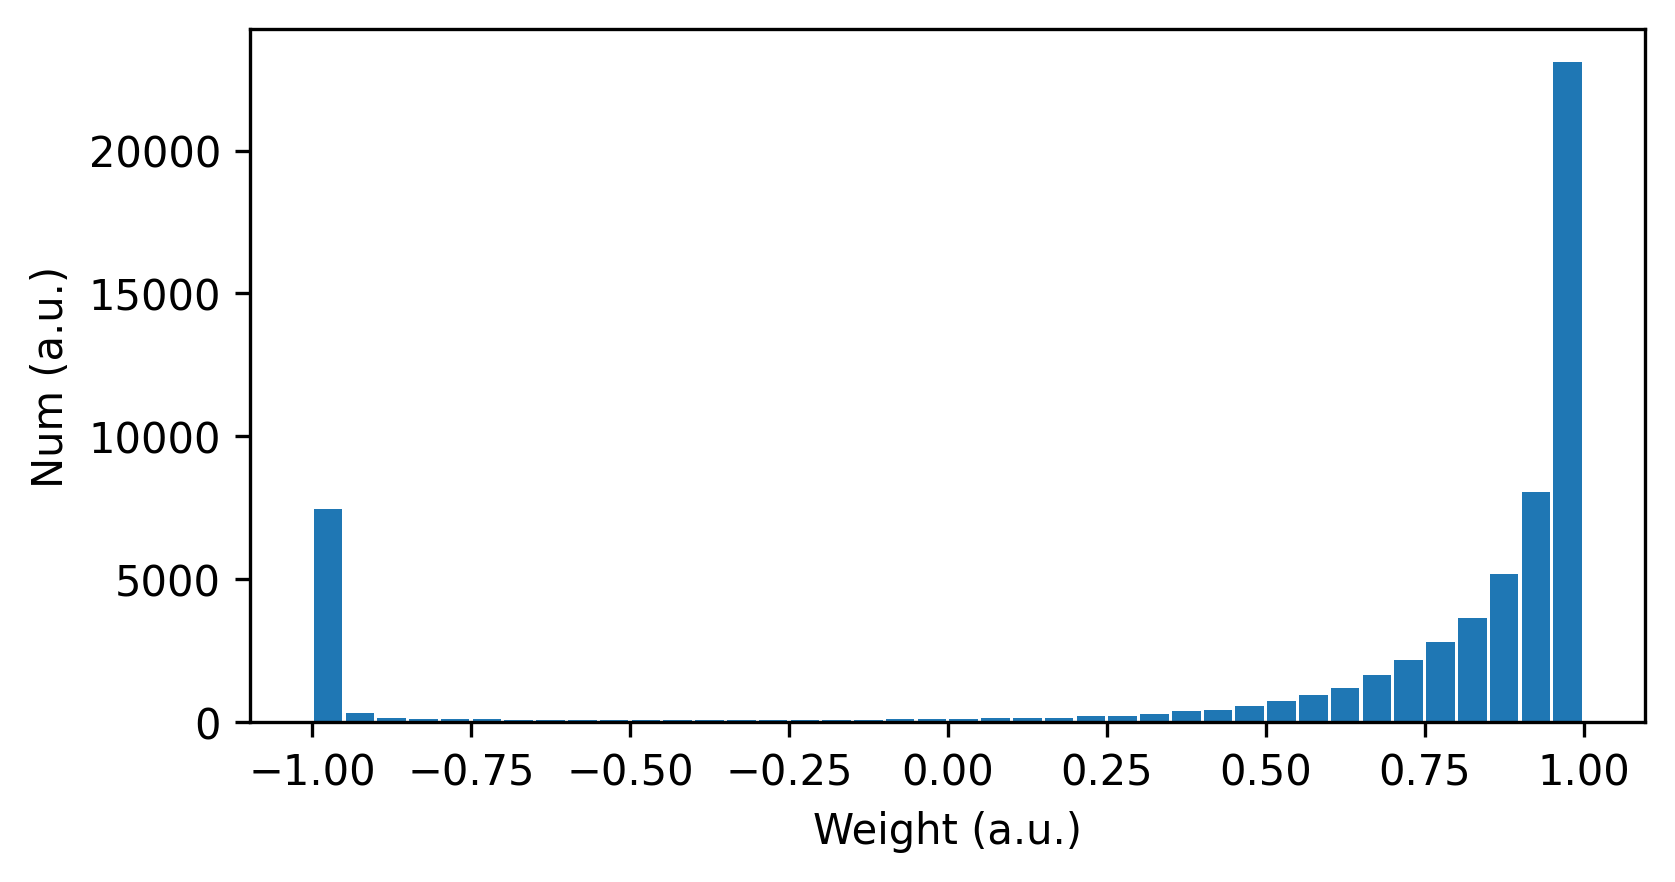

In [53]:
plt.figure(dpi=300,figsize=(6,3))
plt.hist(lorentzian_curve(total_weight, A=1, x0=0, gamma=0.15),bins=40,range=(-1,1),rwidth=0.9)
plt.xlabel('Weight (a.u.)')
plt.ylabel('Num (a.u.)')
plt.show()

In [54]:
file_name = '.\Training results/04-SAT_Lorentz.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net_Lorentz.state_dict(), file_name)
    print('save done')

save done


In [55]:
PATH = '.\Training results/04-SAT_Lorentz.pth'
net = LeNet5()
net.load_state_dict(torch.load(PATH))
net_Lorentz = LeNet5_Lorentz()
net_Lorentz.load_state_dict(torch.load(PATH))
PATH = ""

In [56]:
net.conv1.weight.data = lorentzian_curve(net_Lorentz.conv1.weight.data, A=1, x0=0, gamma=0.15)
net.conv2.weight.data = lorentzian_curve(net_Lorentz.conv2.weight.data, A=1, x0=0, gamma=0.15)
net.fc1.weight.data = lorentzian_curve(net_Lorentz.fc1.weight.data, A=1, x0=0, gamma=0.15)
net.fc2.weight.data = lorentzian_curve(net_Lorentz.fc2.weight.data, A=1, x0=0, gamma=0.15)
net.fc3.weight.data = lorentzian_curve(net_Lorentz.fc3.weight.data, A=1, x0=0, gamma=0.15)

In [57]:
file_name = '.\Training results/04-SAT.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net.state_dict(), file_name)
    print('save done')

save done


### PAT in-situ 

In [14]:
net = LeNet5()
net.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [15]:
### Here the temeprature drift is to emulate the gap between forward physical model and backward ideal model
temperature_drift = -0.5
shift_error = temperature_drift * 80 / 1000 ### thermal coefficient 80pm/K

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 400, gamma = 0.5)

In [17]:
net.to(device)
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        ### Ideal forward
        outputs = net(inputs)
        ### Physical forward (Our experiments perform fc2 & fc3 inference, therefore we add resonance only to fc2 & fc3)
        fc2 = net.fc2.cpu().weight.detach().numpy()
        fc3 = net.fc3.cpu().weight.detach().numpy()
        fc2_noise = lorentzian_curve(lorentzian_inv(fc2,A=1, x0=0, gamma=0.15) + shift_error ,A=1, x0=0, gamma=0.15)
        fc3_noise = lorentzian_curve(lorentzian_inv(fc3,A=1, x0=0, gamma=0.15) + shift_error ,A=1, x0=0, gamma=0.15)  
        net.fc2.weight.data = torch.tensor(fc2_noise).float().to(device)
        net.fc3.weight.data = torch.tensor(fc3_noise).float().to(device)
        net.to(device) 
        with torch.no_grad():
            outputs_phy = net(inputs)
        net.fc2.weight.data = torch.tensor(fc2).float().to(device)
        net.fc3.weight.data = torch.tensor(fc3).float().to(device)
        net.to(device)
        ### Replace phy with ideal
        with torch.no_grad():
            outputs.data.copy_(outputs_phy.data)    
        ### Update ideal model
        loss0 = criterion(outputs, labels)
        loss = loss0
        loss.backward()
        optimizer.step()
        net.apply_constraints()
        running_loss += loss.item()
        if i % 600 == 599:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 600:.3f} Classification loss:{loss0.cpu().detach().numpy():.3f}')
            running_loss = 0.0
    scheduler.step()
    net.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            ### Physical forward
            fc2 = net.fc2.cpu().weight.detach().numpy()
            fc3 = net.fc3.cpu().weight.detach().numpy()
            fc2_noise = lorentzian_curve(lorentzian_inv(fc2,A=1, x0=0, gamma=0.15) + shift_error ,A=1, x0=0, gamma=0.15)
            fc3_noise = lorentzian_curve(lorentzian_inv(fc3,A=1, x0=0, gamma=0.15) + shift_error ,A=1, x0=0, gamma=0.15)        
            net.fc2.weight.data = torch.tensor(fc2_noise).float().to(device)
            net.fc3.weight.data = torch.tensor(fc3_noise).float().to(device)
            net.to(device) 
            outputs = net(inputs)
            net.fc2.weight.data = torch.tensor(fc2).float().to(device)
            net.fc3.weight.data = torch.tensor(fc3).float().to(device)
            net.to(device)              
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy 10000 test images: {100 * correct / total} %')
print('Finished Training')

[1,   600] loss: 3.089 Classification loss:5.635
Accuracy 10000 test images: 38.37 %
[2,   600] loss: 8.004 Classification loss:6.372
Accuracy 10000 test images: 48.27 %
[3,   600] loss: 3.237 Classification loss:0.830
Accuracy 10000 test images: 35.22 %
[4,   600] loss: 3.267 Classification loss:3.673
Accuracy 10000 test images: 92.61 %
[5,   600] loss: 1.106 Classification loss:0.541
Accuracy 10000 test images: 93.59 %
[6,   600] loss: 1.132 Classification loss:1.760
Accuracy 10000 test images: 90.88 %
[7,   600] loss: 1.354 Classification loss:1.190
Accuracy 10000 test images: 93.83 %
[8,   600] loss: 0.740 Classification loss:0.583
Accuracy 10000 test images: 94.36 %
[9,   600] loss: 0.592 Classification loss:0.702
Accuracy 10000 test images: 94.51 %
[10,   600] loss: 0.484 Classification loss:0.001
Accuracy 10000 test images: 96.16 %
[11,   600] loss: 0.437 Classification loss:0.360
Accuracy 10000 test images: 96.25 %
[12,   600] loss: 0.344 Classification loss:0.269
Accuracy 1000

-0.999
0.999


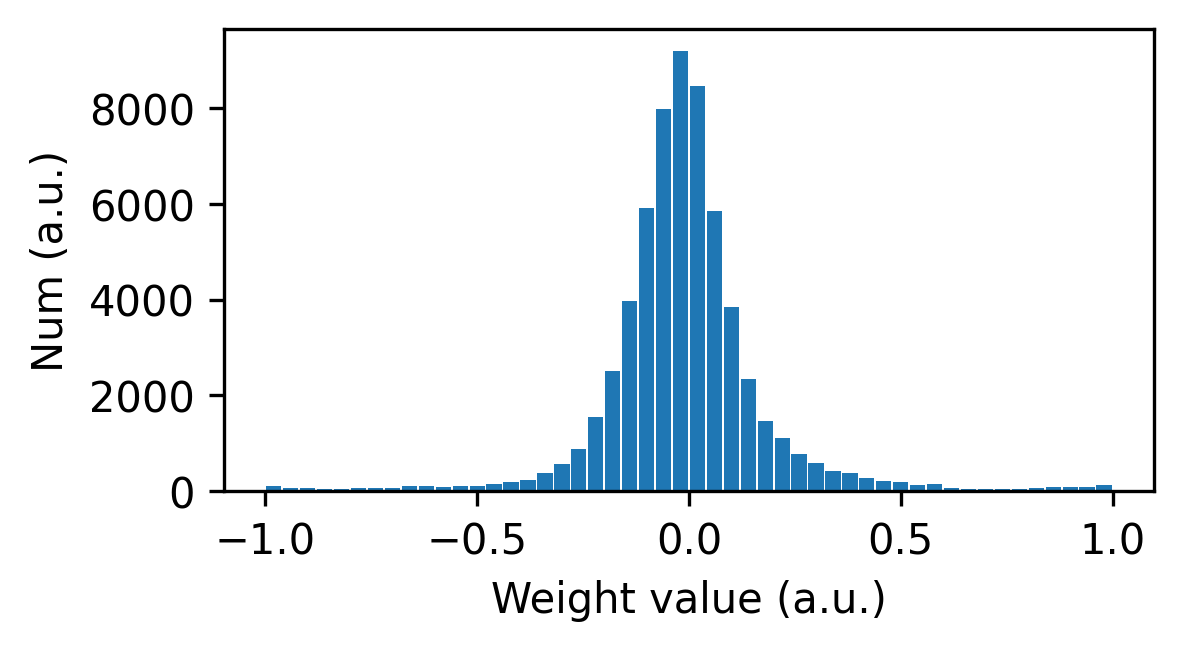

In [18]:
conv1_flat = net.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat,fc3_flat))
print(np.min(total_weight))
print(np.max(total_weight))
plt.figure(figsize=(4,2),dpi=300)
plt.hist(total_weight,bins=50,range=(-1,1),rwidth=0.9)
plt.xlabel('Weight value (a.u.)')
plt.ylabel('Num (a.u.)')
plt.show()

In [19]:
file_name = '.\Training results/05-PAT.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net.state_dict(), file_name)
    print('save done')

save done
